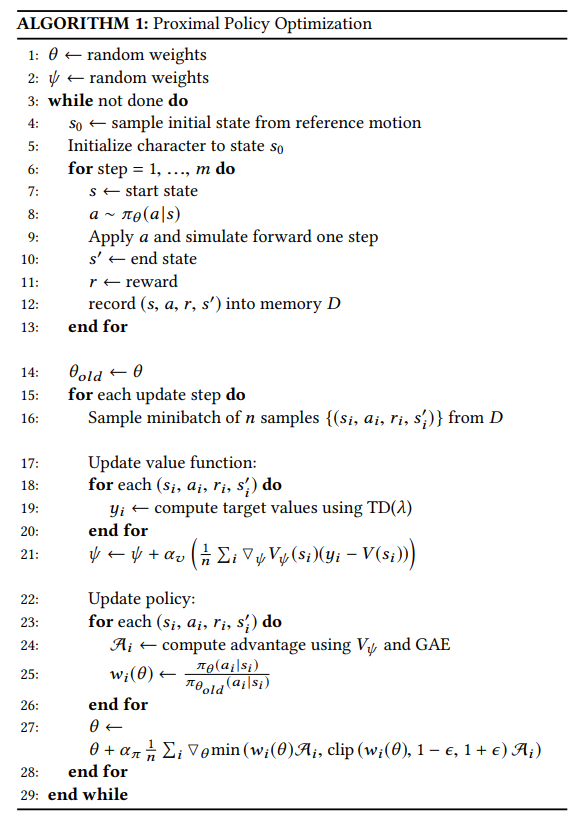

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
train_env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.fc1(x))
        x = F.relu(x)

        x = self.fc2(x)
        return x

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic

    def forward(self, x):
        actions = self.actor(x)
        values = self.critic(x)

        return actions, values

In [7]:
def init_parameters(p):
    if type(p) == nn.Linear:
        nn.init.xavier_normal_(p.weight)
        p.bias.data.fill_(0)

In [8]:
def train(env, policy, gamma, opt, ppo_steps, ppo_clip):
    policy.train()
    ep_reward = 0

    states = []
    actions = []
    values = []
    rewards = []
    log_prob_actions = []

    state = env.reset()
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        states.append(state)

        action_pred, value_pred = policy(state)
        actions_softmax = F.softmax(action_pred, dim=-1)

        dist = distributions.Categorical(actions_softmax)
        action = dist.sample()
        log_prob_a = dist.log_prob(action)
        state, reward, done, _ = env.step(action.item())

        actions.append(action)
        rewards.append(reward)
        log_prob_actions.append(log_prob_a)
        values.append(value_pred)
        ep_reward += reward

    states = torch.cat(states)
    actions = torch.cat(actions)
    log_prob_actions = torch.cat(log_prob_actions).to(device)
    values = torch.cat(values).squeeze(-1).to(device)

    returns = get_returns(rewards, gamma)
    advantages = get_advantages(returns, values)
    policy_loss, value_loss = update_policy(policy, states, actions, log_prob_actions, advantages, returns, opt, ppo_steps, ppo_clip)
    
    return policy_loss, value_loss, ep_reward

In [9]:
def get_returns(rewards, gamma):
    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / returns.std()
    return returns

In [10]:
def get_advantages(returns, values):
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / advantages.std()

    return advantages.to(device)

In [11]:
def update_policy(policy, states, actions, log_prob_actions, advantages, returns, opt, ppo_steps, ppo_clip):
    total_policy_loss = 0 
    total_value_loss = 0

    advantages.detach_()
    log_prob_actions.detach_()
    actions.detach_()

    for _ in range(ppo_steps):
        action_pred, value_pred = policy(states)
        value_pred = value_pred.squeeze(1)
        action_prob = F.softmax(action_pred, dim=-1)
        dist = distributions.Categorical(action_prob)
        new_log_prob_actions = dist.log_prob(actions)

        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_loss_1, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).sum()
        value_loss = F.smooth_l1_loss(returns, value_pred).sum()

        opt.zero_grad()
        policy_loss.backward()
        value_loss.backward()
        opt.step()

        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()

    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [12]:
def evaluate(env, policy):
    policy.eval()
    ep_reward = 0
    state = env.reset()
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            actions, _ = policy(state)
            action = torch.argmax(actions).item()

        state, reward, done, _ = env.step(action)
        ep_reward += reward

    return ep_reward

In [13]:
episodes = 501
gamma = 0.99
input_size = train_env.observation_space.shape[0]
hidden_size = 128
output_size = train_env.action_space.n
ppo_steps = 5
ppo_clip = 0.2
lr = 1e-3

In [14]:
actor = Net(input_size, hidden_size, output_size)
critic = Net(input_size, hidden_size, 1)
policy = ActorCritic(actor, critic)
policy.apply(init_parameters)
policy.to(device)

ActorCritic(
  (actor): Net(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (critic): Net(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [15]:
opt = torch.optim.Adam(policy.parameters(), lr)

In [16]:
policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

In [17]:
for ep in range(episodes):
    policy_loss, value_loss, train_reward = train(train_env, policy, gamma, opt, ppo_steps, ppo_clip)
    test_reward = evaluate(test_env, policy)
    
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    if ep % 50 == 0:
        pl = sum(policy_losses) / len(policy_losses)
        vl = sum(value_losses) / len(value_losses)
        trr = sum(train_rewards) / len(train_rewards)
        ter = sum(test_rewards) / len(test_rewards)
        print(f"episode: {ep} | policy_loss: {pl:.4f} | value_loss: {vl:.4f} | train_reward: {trr} | test_reward: {ter}")

        policy_losses = []
        value_losses = []
        train_rewards = []
        test_rewards = []

episode: 0 | policy_loss: 0.1788 | value_loss: 0.4326 | train_reward: 28.0 | test_reward: 10.0
episode: 50 | policy_loss: 1.1364 | value_loss: 0.3765 | train_reward: 41.14 | test_reward: 134.08
episode: 100 | policy_loss: 2.6771 | value_loss: 0.2915 | train_reward: 84.18 | test_reward: 199.58
episode: 150 | policy_loss: 7.5554 | value_loss: 0.2634 | train_reward: 163.92 | test_reward: 415.8
episode: 200 | policy_loss: 15.7739 | value_loss: 0.3073 | train_reward: 300.56 | test_reward: 500.0
episode: 250 | policy_loss: 18.7693 | value_loss: 0.3341 | train_reward: 333.16 | test_reward: 500.0
episode: 300 | policy_loss: 20.6370 | value_loss: 0.3003 | train_reward: 382.84 | test_reward: 500.0
episode: 350 | policy_loss: 23.7026 | value_loss: 0.3547 | train_reward: 382.98 | test_reward: 500.0
episode: 400 | policy_loss: 21.7910 | value_loss: 0.3718 | train_reward: 369.84 | test_reward: 500.0
episode: 450 | policy_loss: 22.8686 | value_loss: 0.3695 | train_reward: 374.86 | test_reward: 500.0
